##Homework 1  
Statistical Techniques for Data Science and Robotics  
Polina Turishcheva  
Innopolis University, DS-18-02   
February 2022


##SETUP

In [1]:
!pip install sortedcontainers

In [76]:
import numpy as np
import pandas as pd
import math
from sortedcontainers import SortedList
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import sys
import time
sys.setrecursionlimit(1500)

##ALGORITM IMPLEMENTATION

In [96]:
class Tdigest:
  def __init__(self, data, delta=10, k=30):
    # sum of centroid weights
    self.n = 0
    # data is list of pairt [(point, weight)]
    self.delta = delta
    # max number of centroids in the list
    self.k = k
    self.centroids = SortedList()
    self.data_to_centroid(data)

  def copy(self):
    td = Tdigest([], self.delta, self.k)
    td.centroids = self.centroids
    return td
  
  def merge(self, t_digest2):
      self.n = 0
      all_centroids = self.centroids + t_digest2.centroids
      self.centroids = SortedList()
      arr = np.arange(len(all_centroids))
      np.random.shuffle(arr)
      for i in arr:
        p, w, _, _ = all_centroids[i]
        self.add_one_element(p, w)

  def add_one_element(self, point, weight):
    self.n += weight
    if len(self.centroids) == 0:
      # mean, weight, min, max
      self.centroids.add((point, weight, point, point))
    else:
      dist = np.asarray([abs(point - p) for p, _, _, _ in self.centroids])
      # indexes of all min distances
      indexes = np.where(dist == dist.min())[0]
      suitable = 0
      max_suitable_weight = -math.inf
      max_suitable_index = -1
      for i in indexes:
        w_left = sum([el[1] for el in self.centroids[:i]])
        if self.w_bound(w_left, weight) <= 1:
          suitable += 1
          if self.centroids[i][1] > max_suitable_weight:
            max_suitable_weight = self.centroids[i][1]
            max_suitable_index = i
      if suitable > 0:
        p, w, min_, max_ = self.centroids.pop(max_suitable_index)
        self.centroids.add(((point * weight + w * p) / (weight + w), w + weight, 
                            min(min_, point), max(max_, point)))
      else:
        self.centroids.add((point, weight, point, point))
    if len(self.centroids) > self.delta * self.k:
      self.compress()

  def compress(self):
    data = [(i[0], i[1]) for i in self.centroids]
    new_digest = Tdigest(data, self.delta, self.k)
    self.centroids = new_digest.centroids

  def data_to_centroid(self, data):
    for point, weight in data:
      self.add_one_element(point, weight)

  def f_phi(self, phi): 
    # phi is same as k fucntion in the original paper
    return self.delta / 2 / np.pi * np.arcsin(2 * phi - 1)
  
  def w_bound(self, w_left, w):
     return self.f_phi((w_left + w) / self.n) - self.f_phi(w_left / self.n)

  def quantile_calculate(self, q, mode='minmax'):
    assert 0 <= q <= 1, 'The quantile number should be between 0 and 1'
    if q == 0:
      # mean of the min element of min centroid
      return self.centroids[0][2]
    if q == 1:
      # mean of the max element of max centroid
      return self.centroids[-1][3]
    l = len(self.centroids)
    cur_q = 0
    prev_mean = 0
    prev_w = 0
    for i, (p, w, min_, max_) in enumerate(self.centroids):
      if cur_q + w / self.n >= q:
        if mode == 'minmax':
        # linear interpolation to improve the accuracy
          if i == 0:
            res = min_ + (max_ - min_) * q / (w / self.n)
            return res
          else:
            new_q = cur_q + w / self.n
            res = min_ + (max_ - min_) / (new_q - cur_q) * (q - cur_q)
            return res
        else:
          diff = cur_q + w - q
          if diff <= w / 2:
            return prev_mean +(p - prev_mean) * 2 * (q - cur_q + prev_w / 2) / (prev_w + w)
          else:
            if i != l - 1:
              p_next, w_next, _, _ = self.centroids[i + 1]
              return p + (p_next - p) * 2 * (q - cur_q - w / 2) / (w_next + w)
            else:
              return p
      else:
        cur_q += w / self.n
        prev_mean = p
        prev_w = w
        

## DATA SIMULATION AND ALGORITHM ESTIMATION

In [60]:
# SIZE = 10_000_000
SIZE = 10_000
LIMIT = 100_000
QUANTILE_099 = 0.99
QUANTILE_09 = 0.9
QUANTILE_075 = 0.75
QUANTILE_05 = 0.5
QUANTILE_025 = 0.25
QUANTILES = [QUANTILE_099, QUANTILE_09, QUANTILE_075, QUANTILE_05, QUANTILE_025]

In [61]:
data1 = np.random.rand(SIZE,)
data1_td = [(i, 1) for i in data1]
data2 = np.random.randint(SIZE, size=(SIZE,))
data2_td = [(i, 1) for i in data2]
data3 = np.random.randint(100_000, size=(SIZE,))
data3_td = [(i, 1) for i in data3]
data = [data1, data2, data3]
data_td = [data1_td, data2_td, data3_td]

In [62]:
for i in range(1, 4):
  td = Tdigest(data_td[i - 1])
  for j in range(len(QUANTILES)):
    print(f'Numpy-implemented (Theoretical) quantile {QUANTILES[j]} for {i} set of data is {np.quantile(data[i - 1], QUANTILES[j])}')
    print(f'T-digest quantile {QUANTILES[j]} for {i} set of data is {td.quantile_calculate(QUANTILES[j], mode = None)} - Paper Interpolation')
    print(f'T-digest quantile {QUANTILES[j]} for {i} set of data is {td.quantile_calculate(QUANTILES[j])} - MINMAX Interpolation')

Numpy-implemented (Theoretical) quantile 0.99 for 1 set of data is 0.9903718195083424
T-digest quantile 0.99 for 1 set of data is 0.8342506940810539 - Paper Interpolation
T-digest quantile 0.99 for 1 set of data is 0.9873586174969922 - MINMAX Interpolation
Numpy-implemented (Theoretical) quantile 0.9 for 1 set of data is 0.902829271034119
T-digest quantile 0.9 for 1 set of data is 0.8342506940810539 - Paper Interpolation
T-digest quantile 0.9 for 1 set of data is 0.8746019521455655 - MINMAX Interpolation
Numpy-implemented (Theoretical) quantile 0.75 for 1 set of data is 0.7529495480276626
T-digest quantile 0.75 for 1 set of data is 0.8342506940810539 - Paper Interpolation
T-digest quantile 0.75 for 1 set of data is 0.686674176559854 - MINMAX Interpolation
Numpy-implemented (Theoretical) quantile 0.5 for 1 set of data is 0.497073437020391
T-digest quantile 0.5 for 1 set of data is 0.3759570145254291 - Paper Interpolation
T-digest quantile 0.5 for 1 set of data is 0.46662979407375116 - M

##Repeat plots from the original paper

In [81]:
#visualization adopted from https://stackoverflow.com/questions/16592222/matplotlib-group-boxplots
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

In [94]:
deltas = [10, 20, 50, 100, 200, 500, 1000]
N = 100_000
times = 20 
qs = [0.00001, 0.0001, 0.001, 0.01, 0.1, 0.5, 0.9, 0.99, 0.999, 0.9999, 0.99999]
delta_t = 200
deltas_2 = [50, 100, 200, 500, 1000]
qs_2 = [0.00001, 0.0001, 0.001, 0.01]
merge_test = [100, 1000, 10_000, 100_000]

In [98]:
res_dict = dict()
for i, s1 in tqdm_notebook(enumerate(merge_test)):
  data = np.random.uniform(size=s1)
  data_td = [(i, 1) for i in data]
  td1 = Tdigest(data_td, delta=50, k=1000)
  for s2 in tqdm_notebook(merge_test[i:]):
    cur = []
    for _ in range(times):
      td = td1.copy()
      data2 = np.random.uniform(size=s2)
      data_td2 = [(i, 1) for i in data2]
      td2 = Tdigest(data_td2, delta=50, k=1000)
      t0 = time.time()
      td.merge(td2)
      tt = time.time()
      cur.append(tt - t0)
    res_dict[f'{s1}-{s2}'] = cur
    res_dict[f'{s2}-{s1}'] = cur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Text(0, 0.5, 'Time, seconds')

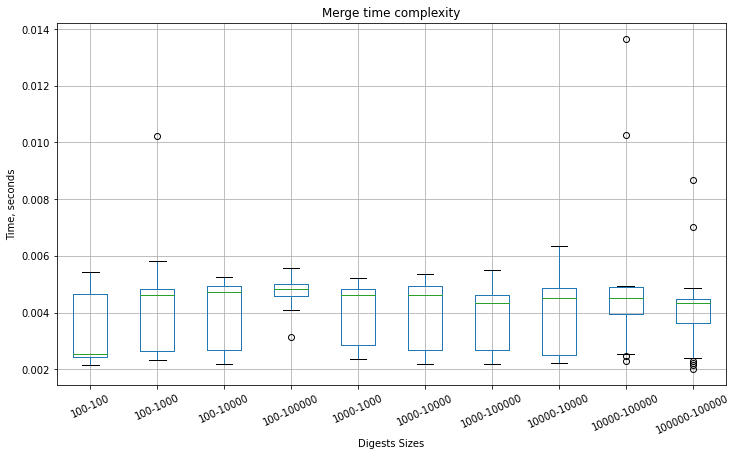

In [100]:
# visualization adopted from https://stackoverflow.com/questions/18500011/horizontal-box-plots-in-matplotlib-pandas
index = []
x = []
for idx, el in enumerate(merge_test):
  for el2 in merge_test[idx:]:
    x.append(res_dict[f'{el}-{el2}'])
    index.append(f'{el}-{el2}')
plt.figure(figsize=(12, 8))
df = pd.DataFrame(x, index=index)  
df.T.boxplot()
plt.subplots_adjust(bottom=0.25)
plt.xticks(rotation=25)
plt.title('Merge time complexity')
plt.xlabel('Digests Sizes')
plt.ylabel('Time, seconds')

In [6]:
#Please note, the execution of this cell may take around hour and a half
res1 = []
res2 = []
res3 = []
time1 = []
time2 = []
time3 = []
for delta in tqdm_notebook(deltas):
  cur1 = []
  cur2 = []
  cur3 = []
  t1 = []
  t2 = []
  t3 = []
  for _ in range(times):
    data = np.random.uniform(size=N)
    data_td = [(i, 1) for i in data]
    t0 = time.time()
    td = Tdigest(data_td, delta=delta, k=N)
    tt = time.time()
    t1.append(tt - t0)
    t0 = time.time()
    td2 = Tdigest(data_td, delta=delta, k=1000)
    tt = time.time()
    t2.append(tt - t0)
    t0 = time.time()
    td3 = Tdigest(data_td, delta=delta, k=100)
    tt = time.time()
    t3.append(tt - t0)
    cur1.append(len(td.centroids)*sys.getsizeof(td.centroids[0]))
    cur2.append(len(td2.centroids)*sys.getsizeof(td2.centroids[0]))
    cur3.append(len(td3.centroids)*sys.getsizeof(td3.centroids[0]))

  res1.append(sum(cur1) / len(cur1))
  res2.append(sum(cur2) / len(cur2))
  res3.append(sum(cur3) / len(cur3))
  time1.append(sum(t1) / len(t1))
  time2.append(sum(t2) / len(t2))
  time3.append(sum(t3) / len(t3))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/7 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Size VS Compression Factor')

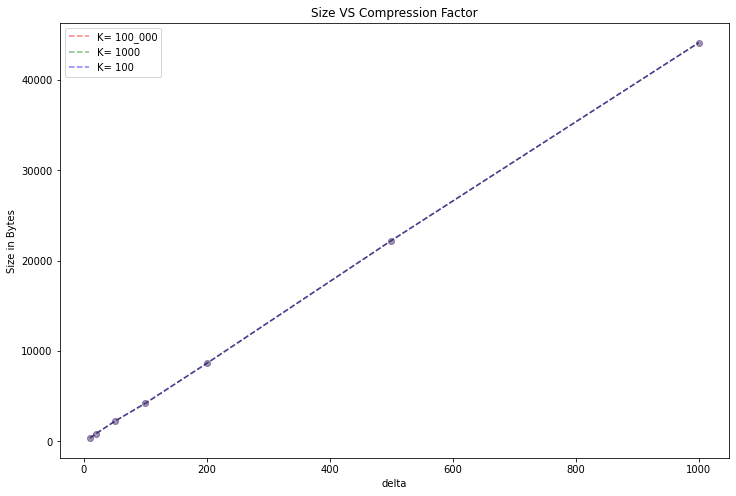

In [36]:
plt.figure(figsize=(12, 8))
plt.plot(deltas, res1, 'r--',  label='K= 100_000', alpha = 0.5)
plt.plot(deltas, res2, 'g--',  label='K= 1000', alpha = 0.5)
plt.plot(deltas, res3, 'b--',  label='K= 100', alpha = 0.5)
plt.plot(deltas, res1, 'ro', alpha = 0.2)
plt.plot(deltas, res2, 'go', alpha = 0.2)
plt.plot(deltas, res3, 'bo', alpha = 0.2)
plt.legend()
plt.xlabel('delta')
plt.ylabel('Size in Bytes')
plt.title('Size VS Compression Factor')

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(deltas, time1, 'r--',  label='K= 100_000', alpha = 0.5)
plt.plot(deltas, time2, 'g--',  label='K= 1000', alpha = 0.5)
plt.plot(deltas, time3, 'b--',  label='K= 100', alpha = 0.5)
plt.plot(deltas, time1, 'ro', alpha = 0.2)
plt.plot(deltas, time2, 'go', alpha = 0.2)
plt.plot(deltas, time3, 'bo', alpha = 0.2)
plt.legend()
plt.xlabel('delta')
plt.ylabel('Time for construction, s')
plt.title('Construction Time VS Compression Factor')

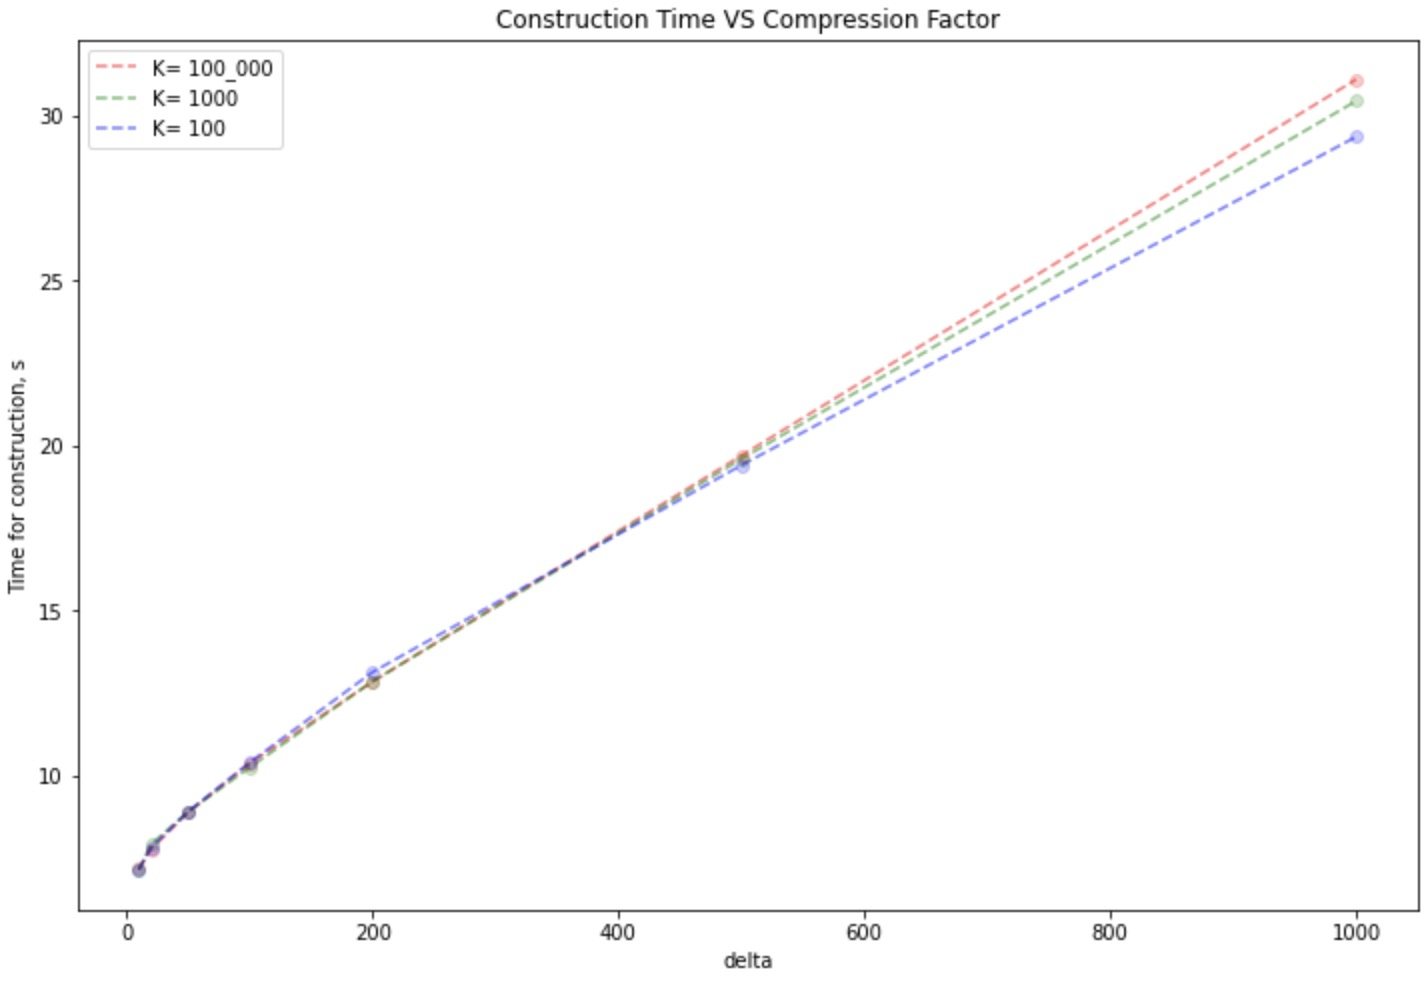

In [70]:
def quartile_accuracy(d, qs):
  res = []
  res_pap = []
  res_stats = []
  res_pap_stats = []
  for q in tqdm_notebook(qs):
    cur = []
    cur_pap = []
    for _ in range(times):
      data = np.random.rand(N,)
      data_td = [(i, 1) for i in data]
      td = Tdigest(data_td, delta=d)
      quan_td = td.quantile_calculate(q)
      quan_td_pap = td.quantile_calculate(q, mode=None)
      quant_theor = np.quantile(data, q)
      cur.append(abs(quant_theor - quan_td))
      cur_pap.append(abs(quant_theor - quan_td_pap))
    res_stats.append(cur)  
    res.append(sum(cur) / len(cur))
    res_pap_stats.append(cur_pap)  
    res_pap.append(sum(cur_pap) / len(cur_pap))
  return res, res_pap, res_stats,  res_pap_stats

In [71]:
res, res_pap, res_stats,  res_pap_stats = quartile_accuracy(delta_t, qs)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/11 [00:00<?, ?it/s]

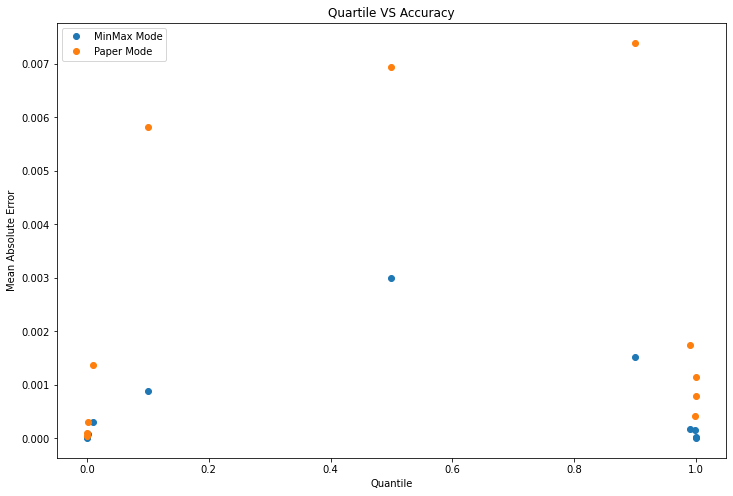

In [75]:
plt.figure(figsize=(12, 8))
plt.plot(qs, res, 'o', label='MinMax Mode')
plt.plot(qs, res_pap, 'o', label='Paper Mode')
plt.xlabel('Quantile')
plt.ylabel('Mean Absolute Error')
plt.title('Quartile VS Accuracy')
plt.legend()

Text(0.5, 1.0, 'Quartile VS Accuracy')

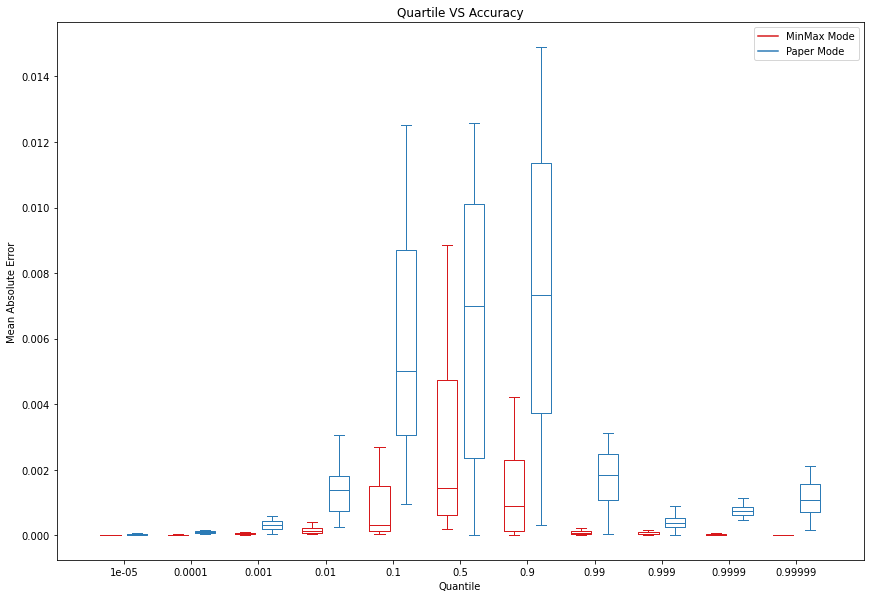

In [88]:
#visualization adopted from https://stackoverflow.com/questions/16592222/matplotlib-group-boxplots
plt.figure(figsize=(12, 8))
bpl = plt.boxplot(res_stats, positions=np.array(range(len(res_stats)))*2.0-0.4, sym='', widths=0.6)
bpr = plt.boxplot(res_pap_stats, positions=np.array(range(len(res_pap_stats)))*2.0+0.4, sym='', widths=0.6)
set_box_color(bpl, '#D7191C') 
set_box_color(bpr, '#2C7BB6')

plt.plot([], c='#D7191C', label='MinMax Mode')
plt.plot([], c='#2C7BB6', label='Paper Mode')
plt.legend()

plt.xticks(range(0, len(qs) * 2, 2), qs)
plt.xlim(-2, len(qs)*2)
plt.tight_layout()
plt.xlabel('Quantile')
plt.ylabel('Mean Absolute Error')
plt.title('Quartile VS Accuracy')

In [89]:
def quartile_accuracy_vs_delta(ds, qs):
  res_dict_fin = dict()
  for q in qs:
    res_dict_fin[q] = [0] * len(ds)
  dicts = []
  for _ in tqdm_notebook(range(times)):
    res_dict = dict()
    for q in qs:
      res_dict[q] = []
    data = np.random.rand(N,)
    data_td = [(i, 1) for i in data]
    for d in ds:
      td = Tdigest(data_td, delta=d)
      for q in qs:
        quan_td = td.quantile_calculate(q)
        quant_theor = np.quantile(data, q)
        res_dict[q].append(abs(quant_theor - quan_td))
    dicts.append(res_dict)
  for q in qs:
    for d in dicts:
      res_dict_fin[q] = [res_dict_fin[q][i] + d[q][i] for i in range(len(ds))]
    res_dict_fin[q] = [res_dict_fin[q][i] / times for i in range(len(ds))]
  return res_dict_fin

In [92]:
res_dict_fin = quartile_accuracy_vs_delta(deltas_2, qs_2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/20 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Quartile VS Accuracy VS Delta')

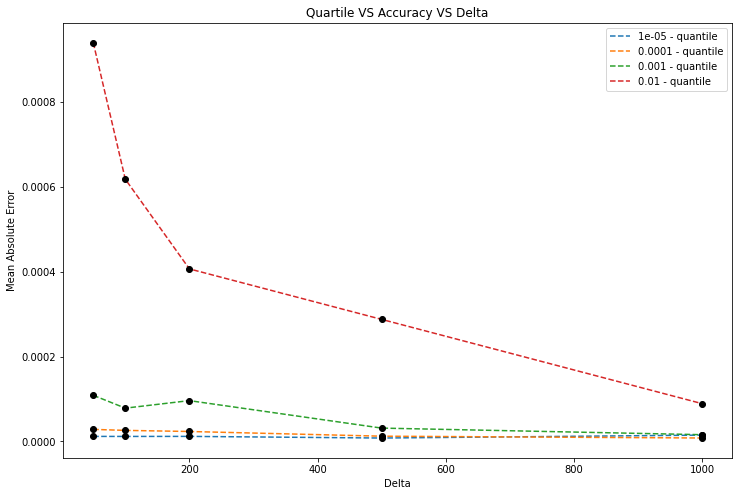

In [93]:
plt.figure(figsize=(12, 8))
for i in res_dict_fin.keys():
  plt.plot(deltas_2, res_dict_fin[i], '--', label = f'{str(i)} - quantile')
  plt.plot(deltas_2, res_dict_fin[i], 'ko')
plt.legend()
plt.ylabel('Mean Absolute Error')
plt.xlabel('Delta')
plt.title('Quartile VS Accuracy VS Delta')